<font color='greyblue'>Sentiment Analysis of Movie Reviews</font>

##Loading the dataset
_______

In [ ]:
#import pandas as pd

#from google.colab import files
#uploaded = files.upload()

In [1]:
import pandas as pd
import io
url = 'https://github.com/bryantanjw/IMDB_Sentiment_Analysis/blob/master/movie_data.csv?raw=true'
df = pd.read_csv(url)

In [ ]:
#import io
#df = pd.read_csv(io.BytesIO(uploaded['movie_data.csv']))

In [2]:
df

,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0
3,hi for all the people who have seen this wonde...,1
4,"I recently bought the DVD, forgetting just how...",0
...,...,...
49995,"OK, lets start with the best. the building. al...",0
49996,The British 'heritage film' industry is out of...,0
49997,I don't even know where to begin on this one. ...,0
49998,Richard Tyler is a little boy who is scared of...,0


In [3]:
df.head(10)

,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0
3,hi for all the people who have seen this wonde...,1
4,"I recently bought the DVD, forgetting just how...",0
5,Leave it to Braik to put on a good show. Final...,1
6,Nathan Detroit (Frank Sinatra) is the manager ...,1
7,"To understand ""Crash Course"" in the right cont...",1
8,I've been impressed with Chavez's stance again...,1
9,This movie is directed by Renny Harlin the fin...,1


In [4]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer()
docs = (['The sun is shining',
         'The weather is sweet',
         'The sun is shining, the weather is sweet, and one and one is two'])
bag = count.fit_transform(docs)

print(count.vocabulary_)
print(bag.toarray())

{'the': 6, 'sun': 4, 'is': 1, 'shining': 3, 'weather': 8, 'sweet': 5, 'and': 0, 'one': 2, 'two': 7}
[[0 1 0 1 1 0 1 0 0]
 [0 1 0 0 0 1 1 0 1]
 [2 3 2 1 1 1 2 1 1]]


In [5]:
from sklearn.feature_extraction.text import TfidfTransformer
np.set_printoptions(precision=2)

tfidf = TfidfTransformer(use_idf=True, norm='l2', smooth_idf=True)

print(tfidf.fit_transform(bag).toarray())

[[0.   0.43 0.   0.56 0.56 0.   0.43 0.   0.  ]
 [0.   0.43 0.   0.   0.   0.56 0.43 0.   0.56]
 [0.5  0.45 0.5  0.19 0.19 0.19 0.3  0.25 0.19]]


#Data Cleaning
___

In [6]:
import re
def preprocessor(text):
  text =re.sub('<[^>]*>', '', text)
  emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
  text = re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', '')

  return text

preprocessor("This is a :) test :-( !")

'this is a test :) :('

In [7]:
# preprocess data
df['review'] = df['review'].apply(preprocessor)

#Tokenization
___

In [8]:
from nltk.stem.porter import PorterStemmer

porter = PorterStemmer()

def tokenizer(text):
  return text.split()

def tokenizer_stemmer(text):
  return[porter.stem(word) for word in text.split()]

tokenizer('runners like running thus they run')

['runners', 'like', 'running', 'thus', 'they', 'run']

In [9]:
tokenizer_stemmer('runners like running thus they run')

['runner', 'like', 'run', 'thu', 'they', 'run']

In [10]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [11]:
from nltk.corpus import stopwords

stop = stopwords.words('english')
[w for w in tokenizer_stemmer('runners like running thus they run') if w not in stop]

['runner', 'like', 'run', 'thu', 'run']

# Transforming the Text Data into TF-IDF Vectors
___

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(strip_accents=None,
                         lowercase=True,
                         preprocessor=None,  # applied preprocessor in Data Cleaning
                         tokenizer=tokenizer_stemmer,
                         use_idf=True,
                         norm='l2',
                         smooth_idf=True)

y = df.sentiment.values
X = tfidf.fit_transform(df.review)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


#Document Classification using Logistic Regression
___

In [13]:
from sklearn.model_selection import train_test_split
import pickle
from sklearn.linear_model import LogisticRegressionCV


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.5, shuffle=False)

clf = LogisticRegressionCV(cv=5,
                           scoring='accuracy',
                           random_state=0,
                           n_jobs=-1,
                           verbose=3,
                           max_iter=300).fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.7s finished


In [14]:
saved_model = open('saved_model.sav', 'wb')
pickle.dump(clf, saved_model)
saved_model.close()

#Model Evaluation
___

In [15]:
filename = 'saved_model.sav'
saved_clf = pickle.load(open(filename, 'rb'))

In [16]:
clf.score(X_test, y_test) #mean accuracy

0.89692

In [17]:
yhat = clf.predict(X_test)
yhat

array([0, 1, 1, ..., 0, 1, 1])

### Confusion matrix

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, yhat, labels=[1,0]))

[[11221  1252]
 [ 1325 11202]]


Confusion matrix, without normalization
[[11221  1252]
 [ 1325 11202]]


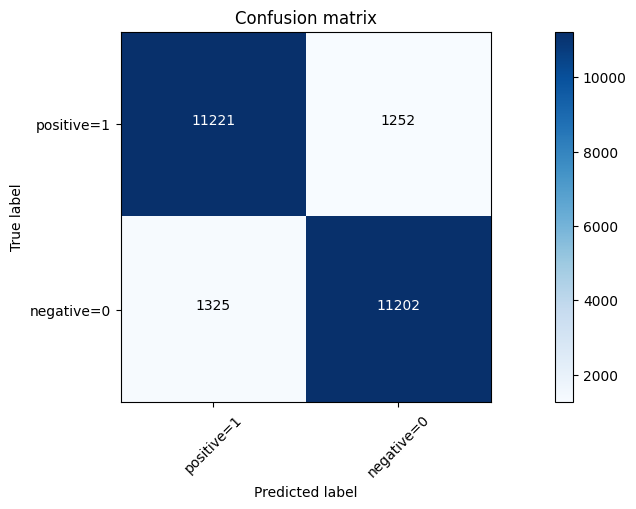

In [19]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure(figsize=(13,5))
plot_confusion_matrix(cnf_matrix, classes=['positive=1','negative=0'],normalize= False,  title='Confusion matrix')

# Stem + step-word removal

In [20]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

porter = PorterStemmer()
stop = set(stopwords.words("english"))

def stem_no_stop(text):
    return " ".join(
        porter.stem(w) for w in text.split() if w not in stop
    )

df["review"] = df["review"].apply(stem_no_stop)

## Train Test split

In [21]:
from sklearn.model_selection import train_test_split
y = df.sentiment.values

## Feature Selection Helper

In [22]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import mutual_info_classif, chi2

def build_tfidf(vocab=None):
    return TfidfVectorizer(
        lowercase=True,
        tokenizer=str.split,
        use_idf=True,
        norm="l2",
        vocabulary=vocab,
    )

def top_k_terms(method, k):
    cv = CountVectorizer(max_df=0.95, min_df=2, max_features=10000)
    X = cv.fit_transform(df.review)
    if method == "ig":
        scores = mutual_info_classif(X, y, discrete_features=True)
    else:  # chi2
        scores, _ = chi2(X, y)
    terms = cv.get_feature_names_out()
    return [t for t, _ in sorted(zip(terms, scores), key=lambda z: z[1], reverse=True)[:k]]


## Classifier list + evaluator

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import mutual_info_classif

def ig_vocab(k=4000):
    cv = CountVectorizer(max_df=0.95, min_df=2, max_features=10000)
    X = cv.fit_transform(df.review)
    scores = mutual_info_classif(X, df.sentiment.values, discrete_features=True)
    terms  = cv.get_feature_names_out()
    top    = [t for t, _ in sorted(zip(terms, scores),
                                   key=lambda z: z[1], reverse=True)[:k]]
    return top

ig_terms = ig_vocab(4000)



In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

tfidf = TfidfVectorizer(vocabulary=ig_terms,
                        lowercase=True,
                        tokenizer=str.split,
                        use_idf=True,
                        norm="l2")

X = tfidf.fit_transform(df.review)
y = df.sentiment.values
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.5,
                                          shuffle=False, random_state=1)


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, f1_score

models = {
    "LogReg":  LogisticRegression(C=4.0, solver="saga",
                                  max_iter=1000, n_jobs=-1),
    "LinSVC":  LinearSVC(),
    "SGD-SVM": SGDClassifier(loss="hinge", alpha=1e-4,
                             random_state=7, max_iter=1000),
}

for name, clf in models.items():
    clf.fit(X_tr, y_tr)
    y_pred = clf.predict(X_te)
    acc = accuracy_score(y_te, y_pred)
    f1  = f1_score(y_te, y_pred)
    print(f"{name:7s}  acc={acc:.3f}  f1={f1:.3f}")


LogReg   acc=0.890  f1=0.890
LinSVC   acc=0.886  f1=0.886
SGD-SVM  acc=0.888  f1=0.889


# Visualizations

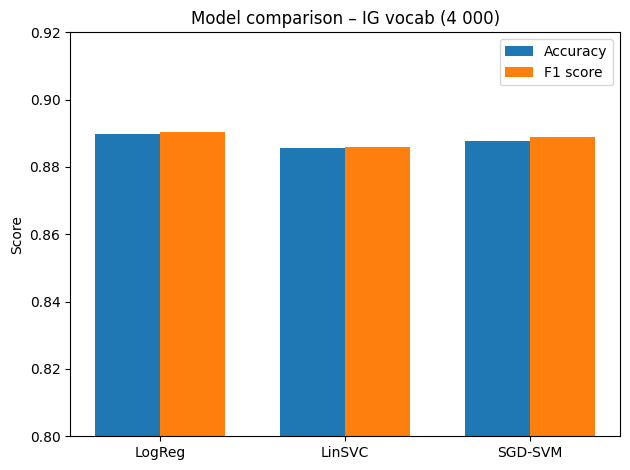

In [26]:
import matplotlib.pyplot as plt
import numpy as np

results = {}
for name, clf in models.items():
    y_pred = clf.predict(X_te)
    results[name] = (
        accuracy_score(y_te, y_pred),
        f1_score(y_te, y_pred)
    )

labels = list(results.keys())
acc = [v[0] for v in results.values()]
f1  = [v[1] for v in results.values()]

x = np.arange(len(labels))
width = 0.35

plt.figure()
plt.bar(x - width/2, acc,  width, label="Accuracy")
plt.bar(x + width/2, f1,   width, label="F1 score")
plt.xticks(x, labels)
plt.ylabel("Score")
plt.ylim(0.80, 0.92)
plt.title("Model comparison – IG vocab (4 000)")
plt.legend()
plt.tight_layout()
plt.show()


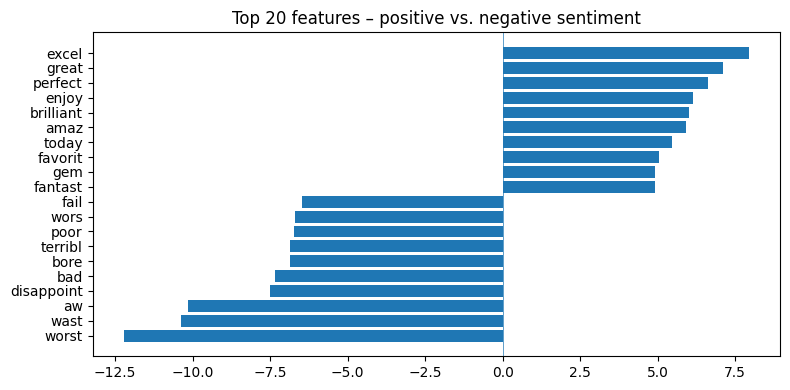

In [28]:
import numpy as np
import matplotlib.pyplot as plt

best_clf = models["LogReg"]

coef = best_clf.coef_.ravel()
top_pos_idx = np.argsort(coef)[-10:]      # most positive weights
top_neg_idx = np.argsort(coef)[:10]       # most negative weights
top_idx = np.hstack([top_neg_idx, top_pos_idx])
terms = np.array(tfidf.get_feature_names_out())[top_idx]
weights = coef[top_idx]

plt.figure(figsize=(8,4))
plt.barh(range(len(top_idx)), weights)
plt.yticks(range(len(top_idx)), terms)
plt.axvline(0, linewidth=0.5)
plt.title("Top 20 features – positive vs. negative sentiment")
plt.tight_layout()
plt.show()
